# Dual_vision测试

In [1]:
import pygame
import matplotlib.pyplot as plt
import env.guide_sim_dual as gs
from env.guide_sim_dual import surf_to_ndarray
import params
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib
from matplotlib import animation
import random
import os

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib
from matplotlib import animation
from ipywidgets.widgets import HTML
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

## 加载导丝仿真环境

In [3]:
dataset_path = "datas/train/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
def _sortfunc(name:str):
    return int(name.split(".")[-2])
tasks.sort(key=_sortfunc)
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])
env.hyper_params.use_soft_task = True

datas/train/no_angiography/1.png
datas/train/label/1.png
datas/train/images/1.png


## 尝试加载导丝环境

([210, 150], [152, 197], 18.0)

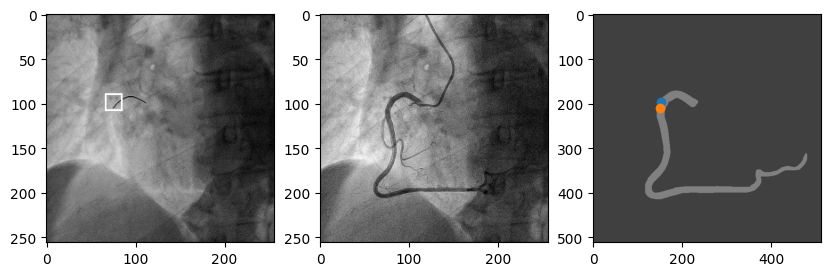

In [ ]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
for _ in range(5):
    img, _, _, _ = env.step(0)
def dual_display(img:np.ndarray, numfig=2):
    # 显示子图，分别显示img[0]和img[1]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, numfig, 1)
    plt.imshow(img[0], cmap='gray')
    plt.subplot(1, numfig, 2)
    plt.imshow(img[1], cmap='gray')
dual_display(img, 3)
plt.subplot(1, 3, 3)
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

# plt.scatter(*env.metadata.target_pos)
plt.scatter(*env.get_now_tip_pos()[::-1])
env.get_now_tip_pos(), env.metadata.target_pos, env.last_a_star

In [ ]:
oo = 

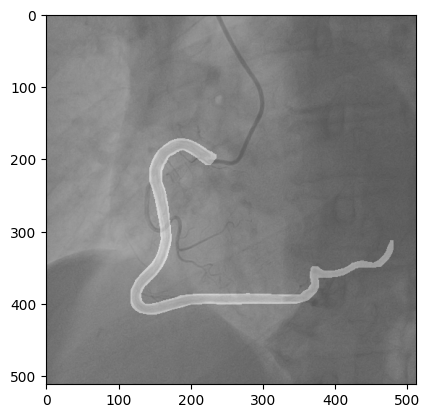

: 

In [ ]:
plt.imshow(surf_to_ndarray(env.mask_surf), cmap='gray', alpha=0.5)
# env.display.blit(env.bg_surf, (0,0))
env.display.blit(pygame.image.load("datas/train/images/1.png"), (0,0))
plt.imshow(surf_to_ndarray(env.display), cmap='gray', alpha=0.5)
# env.display.blit(env.reff_surf, (0,0))
# plt.imshow(surf_to_ndarray(env.display),   cmap='gray', alpha=0.5)

In [5]:
def img_ploter(states:np.ndarray, titles:list) -> plt.Figure:
    """将状态画成图，用于暂存到tensorboard中"""
    num_figs = 0
    if isinstance(states, np.ndarray):
        num_figs = states.shape[0]
    elif isinstance(states, list):
        num_figs = len(states)
    num_rows = num_figs // 5 + 1
    # 生成5列n行的子图
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
    now_row = 0
    for i, state in enumerate(states):
        # state: [2, h, w]
        # 每5个子图后换行
        # 构造一个[h, 2w]的图片，把states的两个通道展示到一张宽图像上
        show_arr = np.zeros((state.shape[1], state.shape[2]*2))
        show_arr[:, :state.shape[2]] = state[0]
        show_arr[:, state.shape[2]:] = state[1]
        if num_rows == 1:
            axs[i%5].imshow(show_arr, cmap="gray")
            axs[i%5].axis('off')
            axs[i%5].set_title(titles[i])
        else:
            axs[now_row, i%5].imshow(show_arr, cmap="gray")
            axs[now_row, i%5].axis('off')
            axs[now_row, i%5].set_title(titles[i])
        if i%5 == 4:
            now_row += 1
    return fig

## 图片做域随机化处理


In [6]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化到[-1, 1]之间
])
def dual_sync_transform(s:np.ndarray, transform: transforms.Compose):
    '''
    s 是输入状态, [2, 256, 256]
    需要使得两个图像获得相同的转换
    '''
    tensor = torch.from_numpy(s).to(dtype=torch.uint8)
    tensor = transform(tensor[:,None,...])  # [2, 1, 256, 256]
    return tensor.squeeze(dim=1).numpy()    # [2, 256, 256]

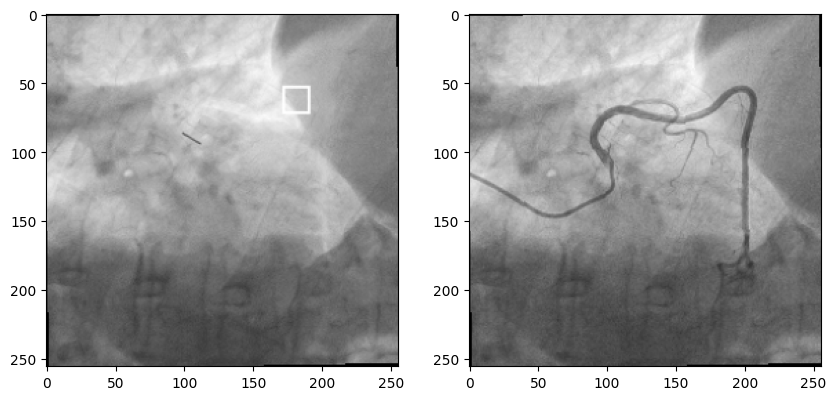

In [7]:
tensor  = dual_sync_transform(img, transform)
dual_display(tensor)

## 尝试交互 (往前推进十次)

24
24
0 -0.3048780487804878 False 1
24
1 0.36585365853658536 False 0
24
2 0.3252032520325203 False 0
24
3 0.5691056910569106 False 0
24
4 1.1788617886178863 False 0
246 192


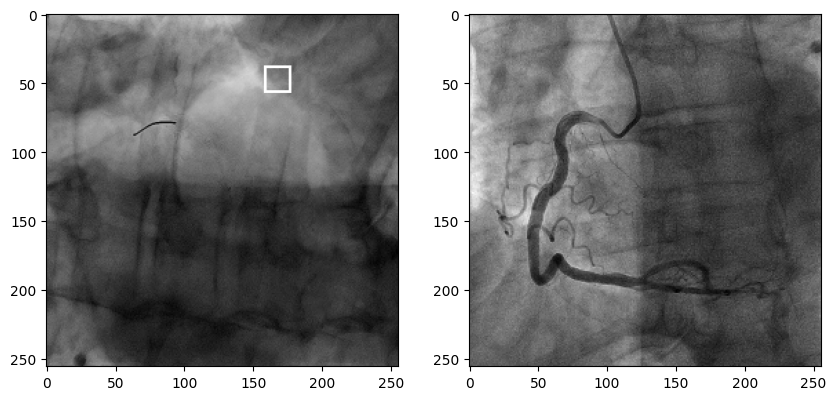

In [4]:
env.reset()
states = []
titles = []
for i in range(5):
    action = random.choice([0, 1])
    img, reward, is_done, _ = env.step(action)  # 执行一个动作（0: 推进， 1： 撤回， 2，3：旋转）
    print(i, reward, is_done, action)
    states.append(img)
    titles.append(f"{i}")
    if is_done:
        break
dual_display(img)
print(env.inial_a_star, env.last_a_star)

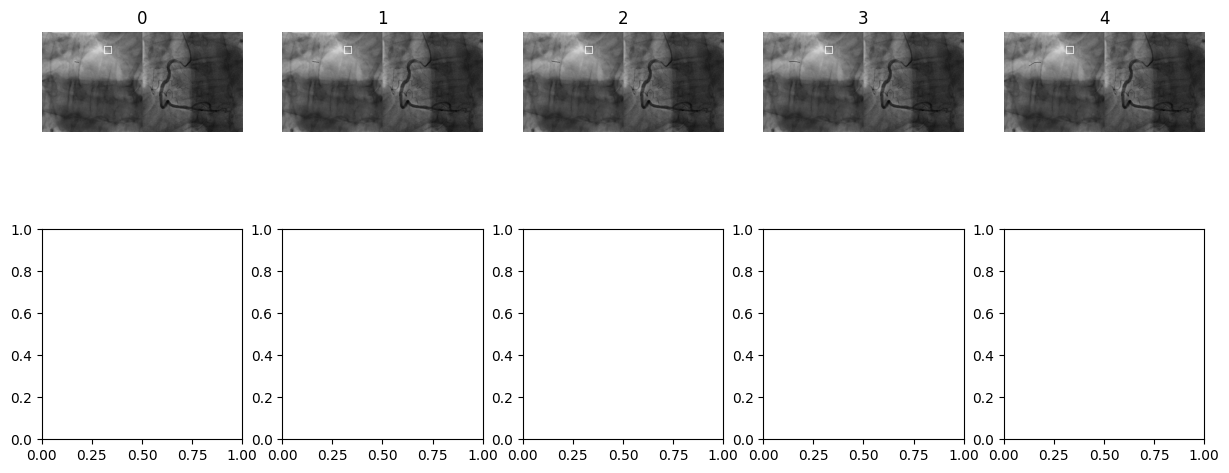

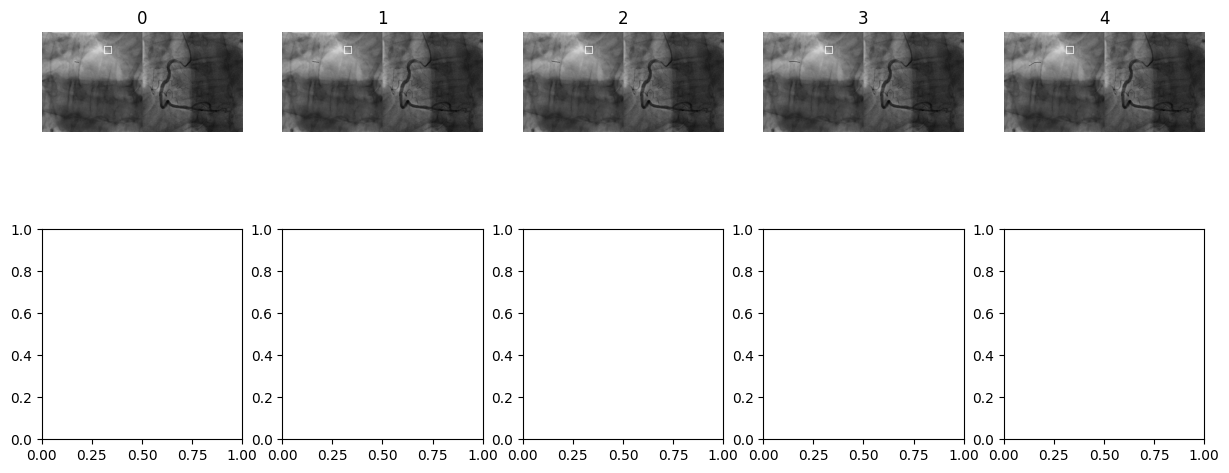

In [8]:
img_ploter(states, titles)

In [26]:
from networks.networks import MODEL_MAPPING

In [34]:
model = MODEL_MAPPING["HYBRID_RESNET18_VIT4"]()
input_image = dual_sync_transform(img, transform)
tensor = torch.from_numpy(input_image).unsqueeze(0)

model(tensor)

(tensor([[0.2148, 0.1700, 0.2673, 0.2972, 0.0507]], grad_fn=<SoftmaxBackward0>),
 tensor([[-0.0839]], grad_fn=<AddmmBackward0>))

([184, 198], [154, 195])

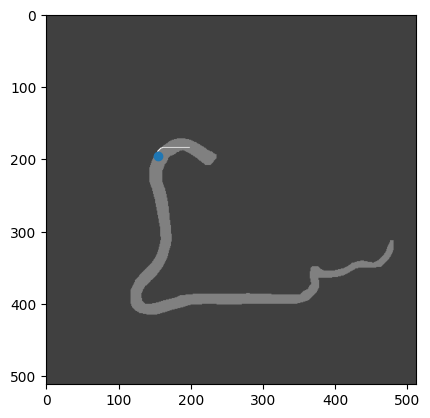

In [ ]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [ ]:

import sys
# 全局定义训练环境
import matplotlib.pyplot as plt
import numpy as np 
from tqdm.notebook import tqdm
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib_inline import backend_inline
from IPython.display import HTML, clear_output
import os
backend_inline.set_matplotlib_formats('svg')
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

我们的目标是训练一个AI，能够根据图像输入学习到将导丝推送到目标位置（白框）

In [ ]:
from agents.ppo import Agent, ReplayData, ExperimentReplayBuffer
from networks.vit import VIT3_FC
from env.metadata import GuideSimMetadata, HyperParams
model = VIT3_FC()
count = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {count}")
agent = Agent(model)
agent.ac_model = model.to(agent.device)
hyper = HyperParams()
hyper.load_from_json("./hyper.json")
agent.set_hyperpara(hyper)
agent.plot_attrs()

## 需要尽可能的提升增加泛化性

这个仿真器提供了多种不同的任务，包括不同形状和大小的目标，不同难度的背景，不同难度的导丝路径

## 尝试使用Qwen2.5VL


In [70]:
from agents.qwen_vl import Agent

In [71]:
openai_api_key = "EMPTY"
openai_api_base = "http://192.168.1.110:1234/v1"
model="qwen2.5-vl-7b-instruct"
agent = Agent(openai_api_key, openai_api_base, model)

In [72]:
chat_response = agent.chat_with_array(img[0],
                    "将导丝递送到白框位置，你可以推进，后退，左转和右转，请输出你认为的导丝动作选择")  # 与agent对话
plt.imshow(img[0], cmap='gray')

APIConnectionError: Connection error.

In [18]:
chat_response.choices[0].message.content  # 获取回复内容

'根据图像显示的信息，导丝已经到达了白框的位置。因此，在这种情况下，不需要进行任何操作来移动或调整导丝。导丝已经在目标位置，可以保持不动。\n\n所以，正确的答案是：无需进行任何操作（即“静止”）。'

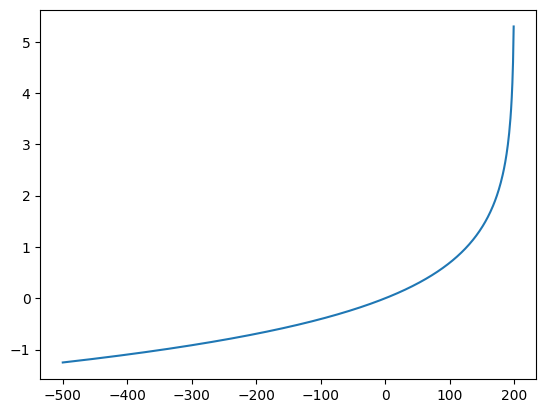

In [ ]:
import math
import numpy as np

def f(x):
    return np.log((200)) - np.log((-x + 200))
x = np.arange(-500, 200, 1)

plt.plot(x, f(x))


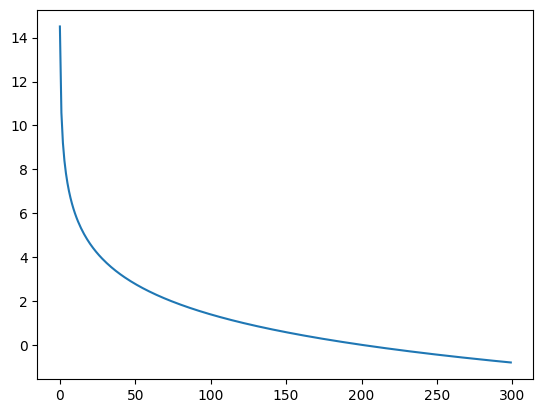

In [99]:
import numpy as np

def merged_formula(x):
    return np.log(200 / (( x ** 2 / 200 ) + 0.0001))

# x变为距离
x = np.arange(0, 300, 1)
plt.plot(x, merged_formula(x))

In [109]:
merged_formula(40)

3.218863324946325

# SoftTask测试

In [1]:
import matplotlib.pyplot as plt
import env.guide_sim_soft_task_ver as gs
from env.guide_sim_soft_task_ver import surf_to_ndarray
import params
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib
from matplotlib import animation
import random
import os
import cv2

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


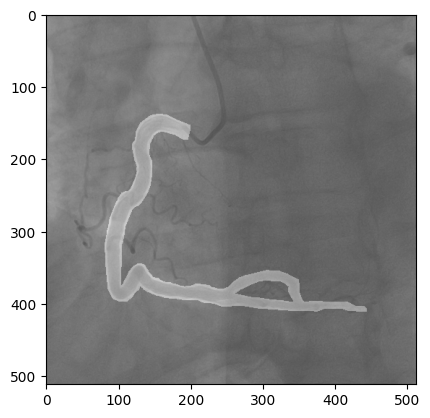

In [2]:
dataset_path = "datas/train/"
# dataset_path = "datas/plastic_tube/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
def _sortfunc(name:str):
    return int(name.split(".")[-2])
tasks.sort(key=_sortfunc)
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[1])
env.hyper_params.soft_task_dist = 70
env.hyper_params.use_soft_task = True
plt.imshow(surf_to_ndarray(env.mask_surf), cmap='gray', alpha=0.5)
env.display.blit(env.bg_surf, (0,0))
plt.imshow(surf_to_ndarray(env.display),   cmap='gray', alpha=0.5)

not iniallized
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到背后的点 (139.4057703711477, 162.15857979653998)
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到背后的点 (201.08288587746634, 141.74127828531635)
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到背后的点 (169.81671941656177, 252.03102951329637)
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到背后的点 (164.9862068174602, 250.89041461867134)
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到背后的点 (124.53441206988745, 213.33175171196373)
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到背后的点 (130.26848164956024, 196.83925699284805)
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到背后的点 (177.75447545367956, 253.7277170144494)
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒

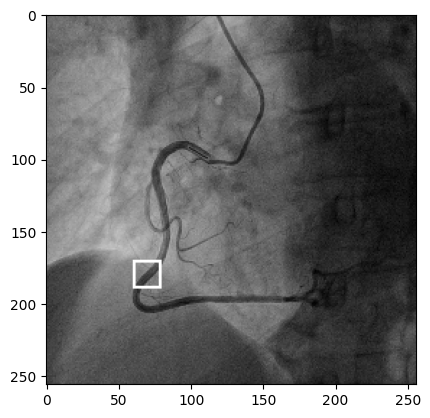

In [10]:

img = env.reset(debug=True)  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
print(img.shape)
plt.imshow(img[0], cmap='gray')
plt.show()

0.13333333333333333 False


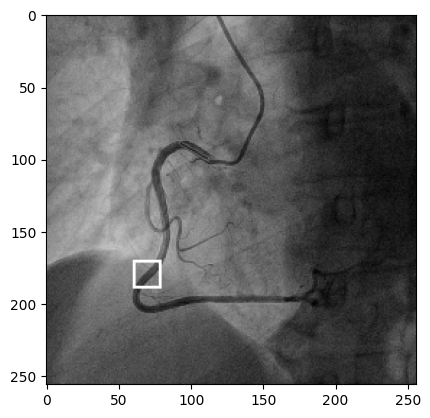

In [4]:
s, r, d, _ = env.step(0)

print(r, d)
plt.imshow(s[0], cmap="gray")
plt.show()

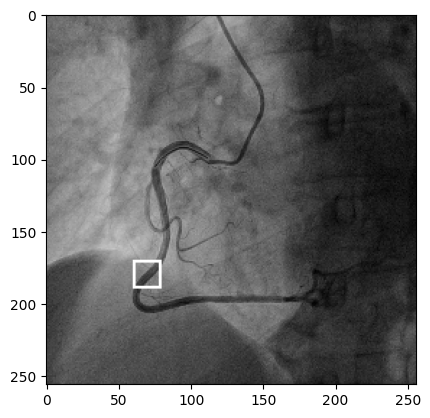

In [11]:
for i in range(5):
    s,_,d,_ = env.step(0)
    # if d == True:
    #     break
plt.imshow(s[0], cmap="gray")
plt.show()


In [3]:
fr = []
for i in range(500):
    s = env.reset(debug=True)
    print(env.get_now_target_pos())
    fr.append(s[0])
    
display_video(fr)


not iniallized
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到背后的点 (169.78306145653463, 211.73790251171255)
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
is_collision:False, resampled_target:(132.42067390366628, 204.87338604473896), soft_task_force_reset_cnt:0, reset all
[204, 132]
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝离圆心太近
拒绝离圆心太近
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到背后的点 (188.59262948771848, 205.33499867891004)
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝采样到圆外的点
拒绝离圆心太近
拒绝采样到圆外的点
拒绝采样到圆外的

NameError: name 'display_video' is not defined

([153, 158], [127, 191])

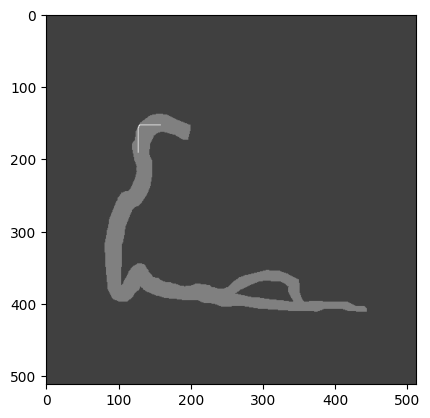

In [4]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [5]:
env.reset()
img = env._mask_surf_np.copy()
x, y = env.get_now_tip_pos()
pos = env.get_now_tip_pos()
pps = []
pps2 = []
pps3 = []
pps4 = []
def l2_distance_square(point1, point2):
    """
    没有开根的欧氏距离 (为了优化计算速度)
    """
    return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2

dist = 45
rejection_min_dist = max(4*env.metadata.radius, dist*0.5)
print(env.line.n, env.line.p0)
for _ in range(1000):
    pos = env.get_now_tip_pos()
    pos = (pos[0] + (1-np.random.normal(0, dist)), pos[1] + (1-np.random.normal(0, dist)))
    sampled_dist = l2_distance_square(pos, env.get_now_tip_pos())
    # 如果采样到的坐标离圆心太近，则拒绝采样
    if sampled_dist < rejection_min_dist**2:
        continue
    # 如果采样到的坐标在圆外，则依旧拒绝采样
    if sampled_dist > dist**2:
        continue
    # if env._mask_surf_np[int(pos[0]), int(pos[1])] == 255:
    #     print(f"Sample goal: {l2_distance_square(pos, env.get_now_tip_pos()) ** 0.5}")
    #     pps.append(pos)
    # s = float(np.dot(env.line.n, pos[::-1] - env.line.p0))
    # print("p=", pos[::-1], "s=", s, "eps=2 ->", s>2, "eps=0.1 ->", s>0.1)
    if not env.line.point_side(pos):
        continue
    pps.append(pos)
        # if env.line.point_side(pos):
        #     pps3.append(pos)
    
    samp = env.sample_goal(dist)
    if samp:
        pps2.append(samp)
        # if env.line.point_side(samp, 2):
        #     pps3.append(samp)
        
pps = np.array(pps)
pps2 = np.array(pps2)
pps3 = np.array(pps3)

pps2.shape

[-0.15596257 -0.987763  ] [158. 188.]


(218, 2)

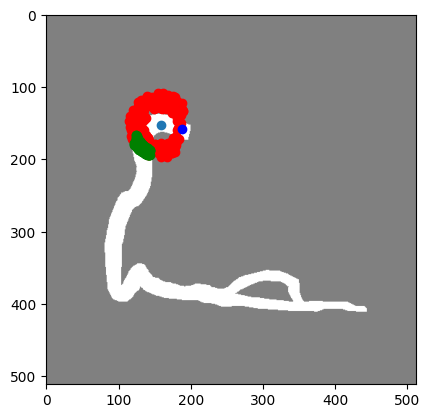

In [6]:
plt.imshow(img, cmap='gray', alpha=0.5)
plt.scatter(y, x)

plt.scatter(pps[:,1], pps[:,0], c='r')
plt.scatter(pps2[:,0], pps2[:,1], c='g')
plt.scatter(env.metadata.insert_pos[0], env.metadata.insert_pos[1], c='b')
# plt.scatter(pps3[:,0], pps3[:,1], c='b')
x1, y1 = env.metadata.insert_pos
x2, y2 = env.metadata.direct_pos
# plt.scatter(y, x)
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
plt.show()


In [ ]:
plt.imshow(img, cmap='gray', alpha=0.5)
plt.scatter(y, x)
# plt.scatter(pps[:,1], pps[:,0], c='r')
plt.scatter(pps2[:,0], pps2[:,1], c='g')
plt.scatter(y, x)
plt.show()


In [5]:
import matplotlib
from matplotlib import animation
from ipywidgets.widgets import HTML
def display_video(frames:list, framerate:int=30, dpi:int=70, channel_first:bool=True):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    if len(frames[0].shape) == 2:
      height, width = frames[0].shape
    elif len(frames[0].shape) == 3:
      if channel_first:
        _, height, width = frames[0].shape
      else:
        height, width, _ = frames[0].shape
      height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())